In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [41]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [42]:
data = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [43]:
data.shape


(35887, 3)

In [44]:
mapping = {
    0:'anger',
    1:'disgust',
    2:'fear',
    3:'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

In [45]:
data.emotion.value_counts()


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [46]:
data.emotion.unique()


array([0, 2, 4, 6, 3, 5, 1])

In [47]:
data.isnull().sum() #checking for total null values

emotion    0
pixels     0
Usage      0
dtype: int64

In [48]:

data.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [49]:

data.iloc[90:110]

,emotion,pixels,Usage
90,0,239 232 251 142 16 0 41 97 46 43 51 77 86 94 9...,Training
91,0,255 255 254 253 250 146 91 64 53 72 68 62 64 7...,Training
92,6,74 58 23 70 110 97 87 78 72 69 66 62 58 56 58 ...,Training
93,0,186 181 178 178 163 84 48 20 18 19 33 86 106 1...,Training
94,6,255 254 254 249 187 183 172 179 182 159 148 14...,Training
95,2,70 81 103 97 81 37 20 19 21 19 15 19 17 15 17 ...,Training
96,2,91 37 22 39 39 32 31 21 34 49 50 50 55 54 49 6...,Training
97,3,15 16 19 22 20 20 20 24 31 50 71 69 78 112 137...,Training
98,4,124 109 86 65 48 35 25 21 23 32 43 59 81 93 10...,Training
99,3,111 106 107 112 89 69 61 59 57 62 83 85 77 81 ...,Training


In [50]:

data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [51]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [52]:
math.sqrt(len(data.pixels[0].split(' ')))


48.0

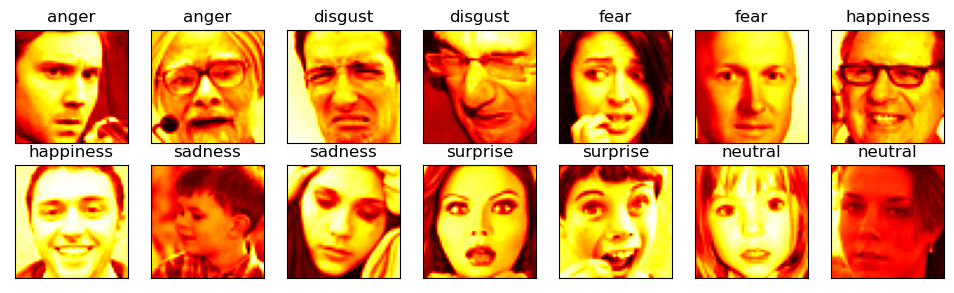

In [53]:
fig = pyplot.figure(1, (12, 12))

imageee = 0
for label in sorted(data.emotion.unique()):
    for j in range(2):
        px = data[data.emotion==label].pixels.iloc[imageee]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        imageee += 1
        ax = pyplot.subplot(7, 7, imageee)
        ax.imshow(px, cmap='hot')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(mapping[label])


In [57]:
 actual_labels= [3, 4, 6, 2, 0, 5] #we are interested in these labels because they are the majority

In [58]:
data = data[data.emotion.isin(actual_labels)]
data.shape

(35340, 3)

In [59]:
neural_data = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
neural_data = np.stack(neural_data, axis=0) #48x48x1 numpy array representing the pixel values of an image to be feed into the neural network

In [60]:
neural_data.shape

(35340, 48, 48, 1)

In [61]:
#applies one-hot encoding to the integer labels using the
#'to_categorical' function from the keras.utils module. This creates a binary matrix
#where each row represents a single image, and each column represents a possible emotion category. 
#The value 1 is placed in the column corresponding to the emotion label of the image, and all other values are 0.


le = LabelEncoder()
img_labels = le.fit_transform(data.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35340, 6)

In [30]:
#his sequence of code creates a dictionary that maps the original categorical emotion labels to their corresponding integer labels generated by the LabelEncoder.
#The first line creates a dictionary using the 'zip' function, which combines the original categorical labels and their corresponding integer labels.
#The 'le.classes_' attribute returns a list of all unique categorical labels in the 'emotion' column of 'data'. The 'le.transform' function applies the LabelEncoder to these unique labels and returns their corresponding integer values.
#The resulting dictionary, 'le_name_mapping', maps each unique categorical label to its corresponding integer label. This can be useful for converting predicted integer labels back to their original categorical labels.
#The final line prints the 'le_name_mapping' dictionary to the console.

In [62]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(neural_data, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((31806, 48, 48, 1), (3534, 48, 48, 1), (31806, 6), (3534, 6))

In [64]:
del data
del neural_data
del img_labels

In [66]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


In [67]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [68]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00004,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [69]:
def my_model(optim):
    """

    """
    layer = Sequential(name='CNN')

    layer.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_1'))
    layer.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_2'))
    layer.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    layer.add(Dropout(0.4, name='dropout_1'))

    layer.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_3'))
    layer.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_4'))
    
    layer.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    layer.add(Dropout(0.4, name='dropout_2'))

    layer.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_5'))
    layer.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_6'))
    
    layer.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    layer.add(Dropout(0.5, name='dropout_3'))

    layer.add(Flatten(name='flatten'))
        
    layer.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    layer.add(BatchNormalization(name='batchnorm_7'))
    
    layer.add(Dropout(0.6, name='dropout_4'))
    
    layer.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    layer.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    layer.summary()
    
    return layer


In [70]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_data = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_data.fit(X_train)

In [74]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 30

   

model = my_model(optimizers.Adam(0.001)) 
history = model.fit_generator(
    train_data.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]
2023-05-11 15:45:02.878644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inCNN/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


993/993 [==============================] - 27s 23ms/step - loss: 2.0307 - accuracy: 0.2362 - val_loss: 1.6021 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 2/30
993/993 [==============================] - 23s 23ms/step - loss: 1.6051 - accuracy: 0.3475 - val_loss: 1.4097 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 3/30
993/993 [==============================] - 22s 22ms/step - loss: 1.4309 - accuracy: 0.4316 - val_loss: 1.2620 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 4/30
993/993 [==============================] - 22s 22ms/step - loss: 1.3301 - accuracy: 0.4779 - val_loss: 1.1649 - val_accuracy: 0.5509 - lr: 0.0010
Epoch 5/30
993/993 [==============================] - 22s 23ms/step - loss: 1.2731 - accuracy: 0.5083 - val_loss: 1.1068 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 6/30
993/993 [==============================] - 23s 23ms/step - loss: 1.2203 - accuracy: 0.5318 - val_loss: 1.1164 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 7/30
993/993 [==============================] - 23s 23ms/step -

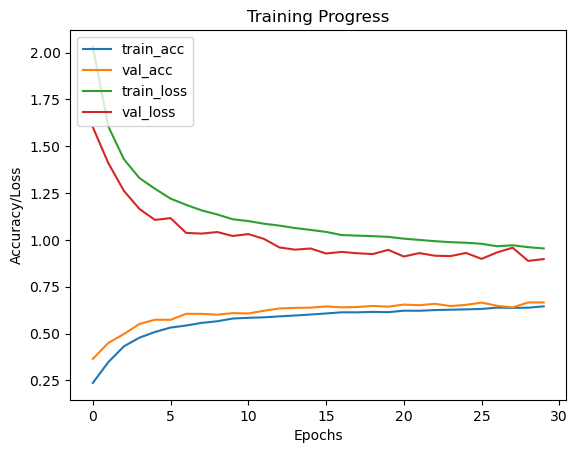

In [75]:
def plot_hist(hist):
    pyplot.plot(hist.history["accuracy"])
    pyplot.plot(hist.history["val_accuracy"])
    pyplot.plot(hist.history["loss"])
    pyplot.plot(hist.history["val_loss"])
    pyplot.title("Training Progress")
    pyplot.ylabel("Accuracy/Loss")
    pyplot.xlabel("Epochs")
    pyplot.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    pyplot.show()


plot_hist(history)


In [76]:
print("Evaluate on test data")
results = model.evaluate(X_valid, y_valid, batch_size=128)
print("test loss, test acc:", results)
#print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
#print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

Evaluate on test data
28/28 [==============================] - 0s 14ms/step - loss: 0.8976 - accuracy: 0.6661
test loss, test acc: [0.897573709487915, 0.6661007404327393]


In [80]:
predict_x=model.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)


111/111 [==============================] - 1s 4ms/step


In [81]:
!pip install scikit-plot

total wrong validation predictions: 1180


              precision    recall  f1-score   support

           0       0.60      0.64      0.62       495
           1       0.57      0.37      0.45       512
           2       0.89      0.84      0.86       899
           3       0.58      0.47      0.52       608
           4       0.74      0.78      0.76       400
           5       0.54      0.81      0.65       620

    accuracy                           0.67      3534
   macro avg       0.65      0.65      0.64      3534
weighted avg       0.67      0.67      0.66      3534



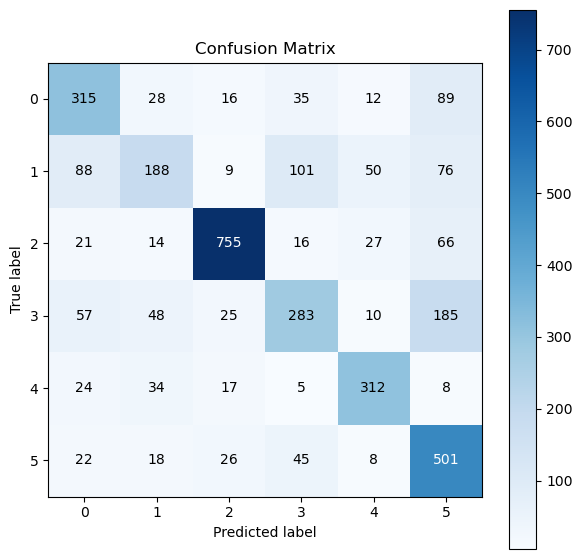

In [86]:
import scikitplot
yhat_valid = classes_x
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))